###  1-Use the datasets library from Hugging Face to download the arabic- generated-abstracts dataset directly into a Python environment (By Google Colab).

In [2]:
from dotenv import load_dotenv
import os
from huggingface_hub import login

load_dotenv()

hf_token = os.getenv("HF_TOKEN")
login(token=hf_token)

In [3]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
dataset = load_dataset("KFUPM-JRCAI/arabic-generated-abstracts")
print(dataset)


DatasetDict({
    by_polishing: Dataset({
        features: ['original_abstract', 'allam_generated_abstract', 'jais_generated_abstract', 'llama_generated_abstract', 'openai_generated_abstract'],
        num_rows: 2851
    })
    from_title: Dataset({
        features: ['original_abstract', 'allam_generated_abstract', 'jais_generated_abstract', 'llama_generated_abstract', 'openai_generated_abstract'],
        num_rows: 2963
    })
    from_title_and_content: Dataset({
        features: ['original_abstract', 'allam_generated_abstract', 'jais_generated_abstract', 'llama_generated_abstract', 'openai_generated_abstract'],
        num_rows: 2574
    })
})


In [4]:
import pandas as pd
# Combine all splits into one df_human
splits = ["by_polishing", "from_title", "from_title_and_content"]

df_human = pd.concat([dataset[s].to_pandas() for s in splits], ignore_index=True)

In [5]:
dfs = []

for split_name in ["by_polishing", "from_title", "from_title_and_content"]:
    split_df = dataset[split_name].to_pandas().copy()
    split_df["source_split"] = split_name   # <-- Create column manually
    dfs.append(split_df)

df_human = pd.concat(dfs, ignore_index=True)

In [6]:
ai_rows = []

for _, row in df_human.iterrows():
    ai_models = [
        ("allam", row["allam_generated_abstract"]),
        ("jais", row["jais_generated_abstract"]),
        ("llama", row["llama_generated_abstract"]),
        ("openai", row["openai_generated_abstract"]),
    ]

    for model_name, text in ai_models:
        ai_rows.append({
            "abstract_text": text,
            "source_split": row["source_split"],     # now this exists
            "generated_by": model_name,
            "label": 0  # AI
        })

# Convert to dataframe
df_ai = pd.DataFrame(ai_rows)

# Create human dataframe
df_h = pd.DataFrame({
    "abstract_text": df_human["original_abstract"],
    "source_split": df_human["source_split"],
    "generated_by": "human",
    "label": 1
})

# Final unified dataset
df = pd.concat([df_h, df_ai], ignore_index=True)

print("Final unified dataset shape:", df.shape)
df.head(10)

Final unified dataset shape: (41940, 4)


,abstract_text,source_split,generated_by,label
0,كثيرا ما ارتبطت المصادر التاريخية في الأندلس خ...,by_polishing,human,1
1,يعد العامل الثقافي احد ابرز الاسباب التي يعزى ...,by_polishing,human,1
2,شكلت تلك الجهود والمساعي الرائدة التي قام بها ...,by_polishing,human,1
3,يقوم المقال على اشكالية الضرائب الغير شرعية في...,by_polishing,human,1
4,تتفق المصادر التاريخية المتوفرة حول موضوع تطور...,by_polishing,human,1
5,تعددت صور الحياة الثقافية و الفكرية و الأدبية ...,by_polishing,human,1
6,تروم هذه المحاولة العلمية المتواضعة رصد ملامح ...,by_polishing,human,1
7,يعالج هذا المقال الإطار التنسيقي بين المنظمات ...,by_polishing,human,1
8,يتناول هذا المقال بالدرس، اقتصاد الأندلس المبن...,by_polishing,human,1
9,نعالج في هذا الموضوع المعنون ب«الثورة التحريري...,by_polishing,human,1


In [7]:
print(df.columns)

Index(['abstract_text', 'source_split', 'generated_by', 'label'], dtype='object')


###  Perform initial data exploration:

#### 1- Load and inspect the dataset structure (columns, data types).


In [8]:
# Inspect column names and data types for one split (e.g., 'by_polishing')
print("\nFeatures in 'by_polishing':")
print(dataset['by_polishing'].features)

# Check dataset info (shape, structure, statistics)
print("\nDataset info for 'by_polishing':")
print(dataset['by_polishing'])





Features in 'by_polishing':
{'original_abstract': Value('string'), 'allam_generated_abstract': Value('string'), 'jais_generated_abstract': Value('string'), 'llama_generated_abstract': Value('string'), 'openai_generated_abstract': Value('string')}

Dataset info for 'by_polishing':
Dataset({
    features: ['original_abstract', 'allam_generated_abstract', 'jais_generated_abstract', 'llama_generated_abstract', 'openai_generated_abstract'],
    num_rows: 2851
})


#### 2- Check the distribution of the target variable (label: human vs. AI- generated)


In [9]:
num_human = df[df["label"] == 1].shape[0]
num_ai = df[df["label"] == 0].shape[0]

total = num_human + num_ai

print("\n===== Target Variable Distribution =====")
print("Human-written abstracts:", num_human)
print("AI-generated abstracts:", num_ai)
print("Human %:", round(num_human / total * 100, 2))
print("AI %:", round(num_ai / total * 100, 2))


===== Target Variable Distribution =====
Human-written abstracts: 8388
AI-generated abstracts: 33552
Human %: 20.0
AI %: 80.0


#### 3- Assess data quality: check for missing values, duplicates, and inconsistencies:


Missing values → any None/NaN in columns

Duplicates → same abstract appearing multiple times

Inconsistencies → like empty strings " " or unusual data

In [10]:
print("\n===== Missing Values =====")
print(df.isnull().sum())

print("\n===== Duplicate Rows =====")
print("Total duplicate rows:", df.duplicated().sum())

print("\n===== Duplicate values per column =====")
for col in df.columns:
    print(f"{col}: {df[col].duplicated().sum()}")

print("\n===== Empty / Blank Values =====")
for col in df.columns:
    empty_count = df[col].apply(lambda x: str(x).strip() == "").sum()
    print(f"{col}: {empty_count}")


===== Missing Values =====
abstract_text    0
source_split     0
generated_by     0
label            0
dtype: int64

===== Duplicate Rows =====
Total duplicate rows: 3

===== Duplicate values per column =====
abstract_text: 5415
source_split: 41937
generated_by: 41935
label: 41938

===== Empty / Blank Values =====
abstract_text: 0
source_split: 0
generated_by: 0
label: 0


# task 2.1: Arabic Text Preprocessing


In [11]:

import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
from datasets import load_dataset


In [12]:
# Download required NLTK resources
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
# Check columns
print(df.head())

                                       abstract_text  source_split  \
0  كثيرا ما ارتبطت المصادر التاريخية في الأندلس خ...  by_polishing   
1  يعد العامل الثقافي احد ابرز الاسباب التي يعزى ...  by_polishing   
2  شكلت تلك الجهود والمساعي الرائدة التي قام بها ...  by_polishing   
3  يقوم المقال على اشكالية الضرائب الغير شرعية في...  by_polishing   
4  تتفق المصادر التاريخية المتوفرة حول موضوع تطور...  by_polishing   

  generated_by  label  
0        human      1  
1        human      1  
2        human      1  
3        human      1  
4        human      1  


In [14]:
#Define Arabic text cleaning functions
# Remove tashkeel (diacritics)
def remove_diacritics(text):
    arabic_diacritics = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    return re.sub(arabic_diacritics, '', text)

In [15]:
# Normalize Arabic text
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("[^؀-ۿ ]+", " ", text)  # remove non-Arabic chars
    return text

In [16]:
# Initialize stopwords and stemmer
arabic_stopwords = set(stopwords.words("arabic"))
stemmer = ISRIStemmer()

In [17]:
# Full preprocessing pipeline
def preprocess_text(text):
    text = str(text)
    text = remove_diacritics(text)
    text = normalize_arabic(text)
    tokens = text.split()
    tokens = [w for w in tokens if w not in arabic_stopwords]
    tokens = [stemmer.stem(w) for w in tokens]
    return " ".join(tokens)

In [18]:
# Apply preprocessing
text_columns = [
    'abstract_text',
    'source_split',
    'generated_by',
    'label',
]

# Apply preprocessing on the unified abstract text column
df["abstract_text_clean"] = df["abstract_text"].apply(preprocess_text)

print("Preprocessing complete! Here are the new columns:")
print(df.columns)

df.head(2)

Preprocessing complete! Here are the new columns:
Index(['abstract_text', 'source_split', 'generated_by', 'label',
       'abstract_text_clean'],
      dtype='object')


,abstract_text,source_split,generated_by,label,abstract_text_clean
0,كثيرا ما ارتبطت المصادر التاريخية في الأندلس خ...,by_polishing,human,1,ربط صدر ارخ دلس خصه كتب رجم هرس رمج وغر درس حي...
1,يعد العامل الثقافي احد ابرز الاسباب التي يعزى ...,by_polishing,human,1,يعد عمل ثقف احد برز سبب يعز سقط دول وحد ، حتي ...




## Features Engineering


In [19]:
#important library
import re
import math
import numpy as np
import pandas as pd
import unicodedata
from collections import Counter
from datasets import load_dataset
import regex as re2  # للاستخدام المتقدم (Arabic support)

In [20]:
#Helper functions


def simple_word_tokenize(text):
    """
    Tokenize text into words / symbols with Arabic support.
    """
    return re2.findall(r"\p{Arabic}+|\w+|[^\s\w]", text, flags=re2.VERSION1)

def sentence_tokenize(text):
    """
    Split text into sentences using Arabic/English punctuation.
    """
    if not isinstance(text, str):
        return []
    parts = re.split(r'(?<=[\.\?\!\u061F\u061B])\s+', text)
    return [p.strip() for p in parts if p.strip()]

def paragraph_tokenize(text):
    """
    Split text into paragraphs based on double newlines.
    """
    if not isinstance(text, str):
        return []
    paragraphs = re.split(r'\s*\n\s*\n\s*|\s*\r\n\s*\r\n\s*', text.strip())
    return [p.strip() for p in paragraphs if p.strip()]


In [21]:
# Column names to use
original_text_columns = "abstract_text"
clean_text_columns = "abstract_text_clean"

# =============================
# 1. Tokens (use clean text)
# =============================
df["tokens"] = df[clean_text_columns].apply(
    lambda t: [tok for tok in simple_word_tokenize(t) if tok.strip()] if isinstance(t, str) else []
)

# =============================
# 2. Words (use clean tokens only)
# =============================
df["words"] = df["tokens"].apply(
    lambda toks: [tok for tok in toks if re.search(r'\w', tok)]
)

# =============================
# 3. Sentences (use original_text_columns for accurate sentence boundary detection)
# =============================
df["sentences"] = df[original_text_columns].apply(
    lambda t: sentence_tokenize(t)
)

# =============================
# 4. Paragraphs (use original_text_columns to preserve original structural breaks)
# =============================
df["paragraphs"] = df[original_text_columns].apply(
    lambda t: paragraph_tokenize(t)
)

print("Feature engineering completed! Columns now:")
print(df.columns)
df.head(2)


Feature engineering completed! Columns now:
Index(['abstract_text', 'source_split', 'generated_by', 'label',
       'abstract_text_clean', 'tokens', 'words', 'sentences', 'paragraphs'],
      dtype='object')


,abstract_text,source_split,generated_by,label,abstract_text_clean,tokens,words,sentences,paragraphs
0,كثيرا ما ارتبطت المصادر التاريخية في الأندلس خ...,by_polishing,human,1,ربط صدر ارخ دلس خصه كتب رجم هرس رمج وغر درس حي...,"[ربط, صدر, ارخ, دلس, خصه, كتب, رجم, هرس, رمج, ...","[ربط, صدر, ارخ, دلس, خصه, كتب, رجم, هرس, رمج, ...",[كثيرا ما ارتبطت المصادر التاريخية في الأندلس ...,[كثيرا ما ارتبطت المصادر التاريخية في الأندلس ...
1,يعد العامل الثقافي احد ابرز الاسباب التي يعزى ...,by_polishing,human,1,يعد عمل ثقف احد برز سبب يعز سقط دول وحد ، حتي ...,"[يعد, عمل, ثقف, احد, برز, سبب, يعز, سقط, دول, ...","[يعد, عمل, ثقف, احد, برز, سبب, يعز, سقط, دول, ...",[يعد العامل الثقافي احد ابرز الاسباب التي يعزى...,[يعد العامل الثقافي احد ابرز الاسباب التي يعزى...


In [22]:
# Column names to use
original_text_columns = "abstract_text"
clean_text_columns = "abstract_text_clean"


In [23]:
# Feature 23: Average Syllables per Word (Appplied on original text columns)
#متوسط عدد المقاطع الصوتية في كل كلمة — يُستخدم لتقييم صعوبة النطق أو القراءة.
# Approximate function to estimate syllables using common vowel grouping
def _estimate_syllables(word):
    """Approximate function to estimate syllables using English vowel grouping."""
    # This function is English-centric. For accurate Arabic NLP, a dedicated Arabic syllabification tool is required.
    vowels = "aeiouAEIOU"
    count = 0
    previous_char_was_vowel = False
    for char in word:
        if char in vowels:
            if not previous_char_was_vowel:
                count += 1
                previous_char_was_vowel = True
        else:
            previous_char_was_vowel = False
    return max(count, 1) # Assumes at least 1 syllable per valid word

def _avg_syllables_per_word(words):
    if not words:
        return 0.0
    return np.mean([_estimate_syllables(w) for w in words])

# Note: Applying to df["words"] (derived from clean text) is more suitable for AWL metrics.
feature_name = f'{clean_text_columns}_f023_avg_syllables_per_word'
df[feature_name] = df["words"].apply(_avg_syllables_per_word)

In [24]:
#!pip install stanza

In [25]:
import stanza
import pandas as pd

# Download Arabic models (do this once)
#stanza.download('ar')  # Arabic models


In [26]:
#Initialize the pipeline for POS tagging
nlp = stanza.Pipeline(lang='ar', processors='tokenize,pos', tokenize_pretokenized=False, use_gpu=False)
pos_tags_col = f'{original_text_columns}_pos_tags'


2025-12-14 18:16:17 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-12-14 18:16:17 INFO: Downloaded file to C:\Users\user\stanza_resources\resources.json
2025-12-14 18:16:17 WARNING: Language ar package default expects mwt, which has been added
2025-12-14 18:16:18 INFO: Loading these models for language: ar (Arabic):
| Processor | Package     |
---------------------------
| tokenize  | padt        |
| mwt       | padt        |
| pos       | padt_charlm |

2025-12-14 18:16:18 INFO: Using device: cpu
2025-12-14 18:16:18 INFO: Loading: tokenize
2025-12-14 18:16:19 INFO: Loading: mwt
2025-12-14 18:16:19 INFO: Loading: pos
2025-12-14 18:16:20 INFO: Done loading processors!


In [27]:
#Function to run Stanza POS tagging
def run_stanza_pos(text, nlp):
    """
    Runs POS tagging on Arabic text using Stanza.
    Returns a list of (word, POS) tuples.
    """
    if not isinstance(text, str) or not text.strip():
        return []
    doc = nlp(text)
    tags = []
    for sent in doc.sentences:
        for word in sent.words:
            tags.append((word.text, word.upos))  # Universal POS tag
    return tags

In [28]:
#Apply POS tagging to cleaned text
df[pos_tags_col] = df[clean_text_columns].apply(lambda t: run_stanza_pos(t, nlp))

In [29]:
# Feature 46: Number of adverbs (approx) بإستخدام قواعد و قاموس للظرف
def _count_possible_adverbs(words):
    """Approximate count of adverbs based on common suffixes and list."""
    if not isinstance(words, list):
        return 0
    suffixes = ('ًا', 'اً', 'ا')
    common_adverbs = {'الآن', 'دائمًا', 'غالبًا', 'أحيانًا', 'سريعًا', 'متأخرًا',
                      'مبكرًا', 'هناك', 'هنا', 'غدًا', 'اليوم', 'حقًا', 'فعلا'}

    return sum(
        1 for w in words
        if any(w.endswith(suf) for suf in suffixes) or w in common_adverbs
    )


df['f046_Number_of_adverbs_(approx)'] = df['words'].apply(_count_possible_adverbs)

In [30]:
# Feature 46: Number of adverbs (approx) بإستخدام مكتبة
#Feature: Number of Adverbs (ADV)
df['abstract_text_f_adverbs'] = df[pos_tags_col].apply(lambda tags: sum(1 for _, tag in tags if tag == 'ADV'))

#Edit all nwe features from here

In [31]:
# Feature 69: Number of dual words (approx) المثنى
for col in original_text_columns:
    morph_features_col = f'{col}_morph_features'

    if morph_features_col in df.columns:
        # الميزة 69: عدد كلمات المثنى (Dual)
        df[f'{col}_f069_num_dual'] = df[morph_features_col].apply(
            # d.get('is_dual', []) تعيد قائمة بالقيم  (True للمثنى)
            lambda d: sum(d.get('is_dual', []))
        )

    else:
        # إذا لم يتم تطبيق التحليل الصرفي، نعود إلى قيمة صفر
        df[f'{col}_f069_num_dual'] = 0

In [34]:
print(original_text_columns, type(original_text_columns))
print(df.columns.tolist())


abstract_text <class 'str'>
['abstract_text', 'source_split', 'generated_by', 'label', 'abstract_text_clean', 'tokens', 'words', 'sentences', 'paragraphs', 'abstract_text_clean_f023_avg_syllables_per_word', 'abstract_text_pos_tags', 'f046_Number_of_adverbs_(approx)', 'abstract_text_f_adverbs', 'a_f069_num_dual', 'b_f069_num_dual', 's_f069_num_dual', 't_f069_num_dual', 'r_f069_num_dual', 'c_f069_num_dual', '__f069_num_dual', 'e_f069_num_dual', 'x_f069_num_dual']


In [35]:
#92. Emotional Valence Score: Mean emotional valence of words.
import regex as re2
import numpy as np

arabic_sentiment_lexicon = {
    "سعيد": 1.0,
    "حزين": -1.0,
    "ممتاز": 0.8,
    "سيء": -0.8,
    "فرح": 0.9,
    "غضب": -0.9,
}

# Minimal tokenizer (so you don't depend on simple_word_tokenize being imported)
def simple_word_tokenize(text):
    if text is None or (isinstance(text, float) and np.isnan(text)):
        return []
    if not isinstance(text, str):
        text = str(text)
    return re2.findall(r"\p{L}+", text)

def emotional_valence_score(text):
    words = simple_word_tokenize(text)
    scores = [arabic_sentiment_lexicon[w] for w in words if w in arabic_sentiment_lexicon]
    return float(np.mean(scores)) if scores else 0.0

# Apply to all text columns (fix: make sure it's treated as a list)
cols = original_text_columns if isinstance(original_text_columns, (list, tuple)) else [original_text_columns]
for col in cols:
    print(f"Processing emotional valence for column: {col}")
    df[f'{col}_emotional_valence'] = df[col].apply(emotional_valence_score)


Processing emotional valence for column: abstract_text


*italicized text*
#Split the data



In [36]:
from sklearn.model_selection import train_test_split

# First split: Train 70%, Temp 30%
train_df, temp_df = train_test_split(df, test_size=0.30, random_state=42, shuffle=True)

# Second split: Temp 30% → 15% Validation, 15% Test
val_df, test_df = train_test_split(temp_df, test_size=0.50, random_state=42, shuffle=True)

# Show sizes
print("TOTAL:", len(df))
print("TRAIN:", len(train_df))
print("VAL:", len(val_df))
print("TEST:", len(test_df))

TOTAL: 41940
TRAIN: 29358
VAL: 6291
TEST: 6291


#TF-IDF Features from Cleaned Text


In [37]:
#apply with abstract_text_clean only
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer for Arabic text
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,   # limit vocabulary
    ngram_range=(1,2),   # unigrams + bigrams
    analyzer='word'
)

# Fit only on training set
tfidf_vectorizer.fit(train_df["abstract_text_clean"])

# Transform train/validation/test sets
X_train_tfidf = tfidf_vectorizer.transform(train_df["abstract_text_clean"])
X_val_tfidf   = tfidf_vectorizer.transform(val_df["abstract_text_clean"])
X_test_tfidf  = tfidf_vectorizer.transform(test_df["abstract_text_clean"])

print("TF-IDF shapes:")
print("Train:", X_train_tfidf.shape)
print("Validation:", X_val_tfidf.shape)
print("Test:", X_test_tfidf.shape)

TF-IDF shapes:
Train: (29358, 5000)
Validation: (6291, 5000)
Test: (6291, 5000)


##Define X and y

In [38]:
from scipy.sparse import hstack


In [39]:
#Select numeric features (The generated feature engineering exclude label and text)
EXCLUDED_COLS = ['label', 'abstract_text', 'abstract_text_clean',
                 'tokens', 'words', 'sentences', 'paragraphs', 'abstract_text_pos_tags']
# Select columns that are numeric AND not in the exclusion list>>feature engineering columns
numeric_cols = [
    col for col in train_df.select_dtypes(include=np.number).columns.tolist()
    if col not in EXCLUDED_COLS
]
# Convert the numeric features DataFrames to NumPy arrays (dense matrices)
# We must use the values/to_numpy() method to extract the array for sparse matrix stacking.
X_train_num_array = train_df[numeric_cols].values
X_val_num_array   = val_df[numeric_cols].values
X_test_num_array  = test_df[numeric_cols].values


# Target variable
y_train = train_df["label"]
y_val   = val_df["label"]
y_test  = test_df["label"]

# Features: TF-IDF and the creating feature engineering
X_train = hstack([X_train_tfidf, X_train_num_array]).tocsr()
X_val= hstack([X_val_tfidf, X_val_num_array]).tocsr()
X_test= hstack([X_test_tfidf, X_test_num_array]).tocsr()

print("X and y are ready for ML models.")
print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

X and y are ready for ML models.
Train: (29358, 5013) (29358,)
Validation: (6291, 5013) (6291,)
Test: (6291, 5013) (6291,)


#Build Machine learning Models

##1-Baseline Model (Naïve Bayes & Logistic Regression)

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the model
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# Train on training set
lr_model.fit(X_train, y_train)

# Predict on validation set
y_val_pred = lr_model.predict(X_val)

# Evaluate on validation set
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report (Validation):")
print(classification_report(y_val, y_val_pred))

Validation Accuracy: 0.9607375615959307

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4977
           1       0.94      0.87      0.90      1314

    accuracy                           0.96      6291
   macro avg       0.95      0.93      0.94      6291
weighted avg       0.96      0.96      0.96      6291



Test Accuracy: 0.9631219202034653

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4978
           1       0.94      0.88      0.91      1313

    accuracy                           0.96      6291
   macro avg       0.95      0.93      0.94      6291
weighted avg       0.96      0.96      0.96      6291



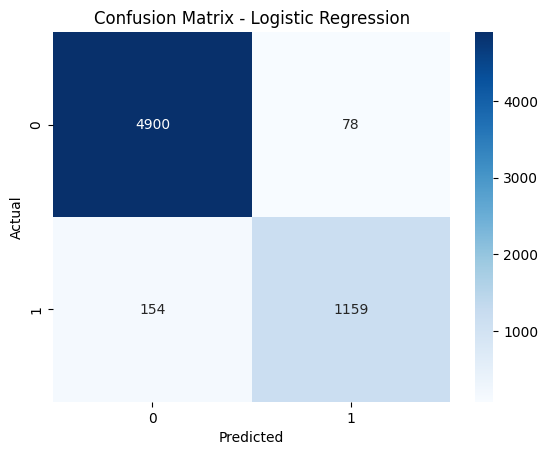

In [41]:
# Evaluation
# Predict on test set
y_test_pred = lr_model.predict(X_test)

# Evaluate on test set
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))

# Optional: confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

##2-Traditional Machine Learning Models ( Support Vector Machine (SVM), Random Forest, XGBoost)using the validation set

In [44]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

# Dictionary to store models and results
models = {}

# -----------------------
#Support Vector Machine (SVM)
# -----------------------
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train, y_train)

y_val_pred_svm = svm_model.predict(X_val)
print("SVM Validation Accuracy:", accuracy_score(y_val, y_val_pred_svm))
print(classification_report(y_val, y_val_pred_svm))

models['SVM'] = svm_model

# -----------------------
#Random Forest
# -----------------------
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

y_val_pred_rf = rf_model.predict(X_val)
print("Random Forest Validation Accuracy:", accuracy_score(y_val, y_val_pred_rf))
print(classification_report(y_val, y_val_pred_rf))

models['RandomForest'] = rf_model

# -----------------------
#XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)

y_val_pred_xgb = xgb_model.predict(X_val)
print("XGBoost Validation Accuracy:", accuracy_score(y_val, y_val_pred_xgb))
print(classification_report(y_val, y_val_pred_xgb))

models['XGBoost'] = xgb_model

SVM Validation Accuracy: 0.9737720553171197
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4977
           1       0.93      0.94      0.94      1314

    accuracy                           0.97      6291
   macro avg       0.96      0.96      0.96      6291
weighted avg       0.97      0.97      0.97      6291

Random Forest Validation Accuracy: 0.9766332856461611
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4977
           1       0.97      0.92      0.94      1314

    accuracy                           0.98      6291
   macro avg       0.97      0.96      0.96      6291
weighted avg       0.98      0.98      0.98      6291



C:\Users\user\.conda\envs\Ai331\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:05:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Validation Accuracy: 0.9688443808615482
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4977
           1       0.93      0.93      0.93      1314

    accuracy                           0.97      6291
   macro avg       0.95      0.95      0.95      6291
weighted avg       0.97      0.97      0.97      6291




===== SVM Test Evaluation =====
Accuracy: 0.9742489270386266

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      4978
           1       0.92      0.95      0.94      1313

    accuracy                           0.97      6291
   macro avg       0.96      0.97      0.96      6291
weighted avg       0.97      0.97      0.97      6291



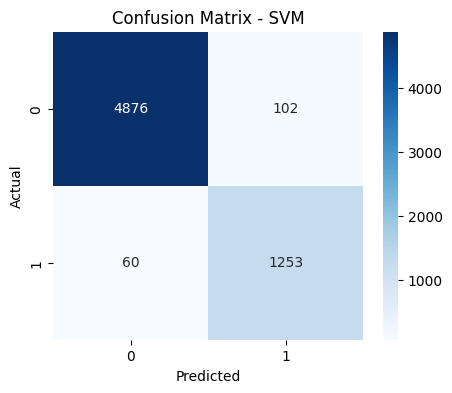


===== RandomForest Test Evaluation =====
Accuracy: 0.9779049435701797

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4978
           1       0.96      0.93      0.95      1313

    accuracy                           0.98      6291
   macro avg       0.97      0.96      0.97      6291
weighted avg       0.98      0.98      0.98      6291



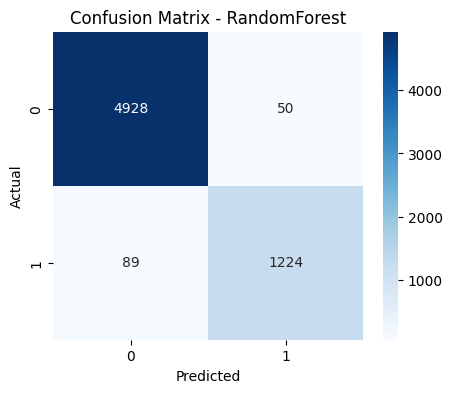


===== XGBoost Test Evaluation =====
Accuracy: 0.9707518677475759

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4978
           1       0.92      0.94      0.93      1313

    accuracy                           0.97      6291
   macro avg       0.95      0.96      0.96      6291
weighted avg       0.97      0.97      0.97      6291



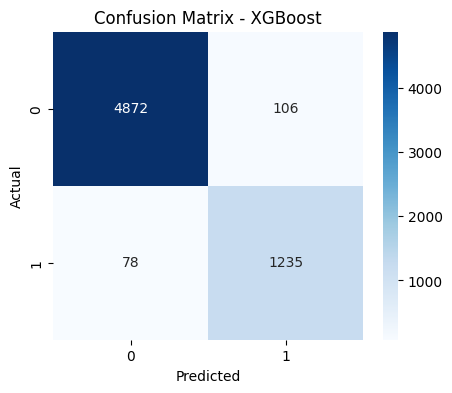

In [45]:
#Evaluation
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# List of models to evaluate
model_names = ['SVM', 'RandomForest', 'XGBoost']

for name in model_names:
    model = models[name]

    # Predict on test set
    y_test_pred = model.predict(X_test)

    print(f"\n===== {name} Test Evaluation =====")
    print("Accuracy:", accuracy_score(y_test, y_test_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

#Build Deep learning Models

##Build neural network classifier ( simple Feedforward Network) on top of the extracted BERT embeddings or fine-tune the pre-trained BERT model for the classification task.

#Step1: Extract BERT Embeddings (Sentence-level)

In [50]:
from sentence_transformers import SentenceTransformer
import numpy as np

bert_model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

# Use your existing cleaned-text column name
X_train_emb = bert_model.encode(train_df["abstract_text_clean"].fillna("").astype(str).tolist(), convert_to_numpy=True)
X_val_emb   = bert_model.encode(val_df["abstract_text_clean"].fillna("").astype(str).tolist(), convert_to_numpy=True)
X_test_emb  = bert_model.encode(test_df["abstract_text_clean"].fillna("").astype(str).tolist(), convert_to_numpy=True)

y_train = train_df["label"].values
y_val   = val_df["label"].values
y_test  = test_df["label"].values

print("Train embedding shape:", X_train_emb.shape)


Train embedding shape: (29358, 384)


##Step 2: Build a Feedforward Neural Network

In [51]:
#import tensorflow as tf
from tensorflow.keras import layers, models

# Basic feedforward classifier on embeddings
ffnn_model = models.Sequential([
    layers.Input(shape=(X_train_emb.shape[1],)),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")   # binary classification
])

ffnn_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


ffnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,585 (514.00 KB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 0 (0.00 B)

##Step3: Train the Model

In [52]:
history = ffnn_model.fit(
    X_train_emb, y_train,
    validation_data=(X_val_emb, y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
918/918 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8113 - loss: 0.4160 - val_accuracy: 0.8023 - val_loss: 0.3886
Epoch 2/10
918/918 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8327 - loss: 0.3682 - val_accuracy: 0.8256 - val_loss: 0.3650
Epoch 3/10
918/918 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8415 - loss: 0.3477 - val_accuracy: 0.8509 - val_loss: 0.3405
Epoch 4/10
918/918 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8463 - loss: 0.3370 - val_accuracy: 0.8313 - val_loss: 0.3523
Epoch 5/10
918/918 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8521 - loss: 0.3278 - val_accuracy: 0.8512 - val_loss: 0.3351
Epoch 6/10
918/918 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8535 - loss: 0.3196 - val_accuracy: 0.8463 - val_loss: 0.3236
Epoch 7/10
918/918 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8600 - loss: 0.3090 - val_accuracy: 0.8627 - val_loss: 0.3139
Epoch 8/10
918/918 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8622 - loss: 0.3032 - val_accuracy: 0.

##Step 4: Evaluate on Test Set

In [53]:
from sklearn.metrics import accuracy_score, classification_report

# Predict
y_test_pred = (ffnn_model.predict(X_test_emb) > 0.5).astype(int)

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step
Test Accuracy: 0.8594817993959625
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      4978
           1       0.78      0.45      0.57      1313

    accuracy                           0.86      6291
   macro avg       0.83      0.71      0.74      6291
weighted avg       0.85      0.86      0.84      6291



##Save Models

In [54]:
import os
import joblib
from tensorflow.keras.models import Model as KerasModel

def save_all_models(models_dict, save_dir="models"):
    """
    Saves all ML/DL models to disk based on their type.

    Parameters:
    -----------
    models_dict : dict
        Example:
            {
                "logistic_regression": log_reg_model,
                "svm": svm_model,
                "random_forest": rf_model,
                "xgboost": xgb_model,
                "ffnn": ffnn_model
            }

    save_dir : str
        Directory where models will be saved.
    """

    # Create save folder
    os.makedirs(save_dir, exist_ok=True)

    for model_name, model_obj in models_dict.items():

        # Case 1 — Keras deep learning model
        if isinstance(model_obj, KerasModel):
            file_path = os.path.join(save_dir, f"{model_name}.h5")
            model_obj.save(file_path)
            print(f"[Saved] Keras model → {file_path}")

        # Case 2 — All pickle-compatible models (Sklearn, XGBoost)
        else:
            file_path = os.path.join(save_dir, f"{model_name}.pkl")
            joblib.dump(model_obj, file_path)
            print(f"[Saved] Pickle model → {file_path}")

    print("\nAll models saved successfully!")

In [55]:
import os
os.makedirs("models", exist_ok=True)
models_dict = {
    "lr_model": lr_model,
    "svm": svm_model,
    "random_forest": rf_model,
    "xgboost": xgb_model,
    "ffnn": ffnn_model
}

save_all_models(models_dict)

[Saved] Pickle model → models\lr_model.pkl
[Saved] Pickle model → models\svm.pkl
[Saved] Pickle model → models\random_forest.pkl
[Saved] Pickle model → models\xgboost.pkl
[Saved] Keras model → models\ffnn.h5

All models saved successfully!
